In [2]:

import os
import numpy as np
import torch
from torch import nn
from scipy.stats import ortho_group
from typing import Union
from typing_extensions import Literal
from pytorch_lightning import LightningModule, Trainer
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from torchvision.datasets import MNIST
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 10000 if AVAIL_GPUS else 64
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.linalg import block_diag
from sklearn.linear_model import LinearRegression
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

## Standard MCC

In [3]:
# Input (true Z) (predicted Zp)
def MCC(Z,Zp):
    n = np.shape(Z)[1]
#     print (n)
    rho_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            rho_matrix[i,j] = np.abs(np.corrcoef(Z[:,i], Zp[:,j])[0,1])
    
    r,c = linear_sum_assignment(-rho_matrix)
    
    return np.mean(rho_matrix[r,c])

## Invertible MLP function from CIDGP paper

In [4]:
def construct_invertible_mlp(
    n: int = 20,
    n_layers: int = 2,
    n_iter_cond_thresh: int = 10000,
    cond_thresh_ratio: float = 0.25,
    weight_matrix_init: Union[Literal["pcl"], Literal["rvs"]] = "pcl",
    act_fct: Union[
        Literal["relu"],
        Literal["leaky_relu"],
        Literal["elu"],
        Literal["smooth_leaky_relu"],
        Literal["softplus"],
    ] = "leaky_relu",
):
   
    """
    Create an (approximately) invertible mixing network based on an MLP.
    Based on the mixing code by Hyvarinen et al.
    Args:
        n: Dimensionality of the input and output data
        n_layers: Number of layers in the MLP.
        n_iter_cond_thresh: How many random matrices to use as a pool to find weights.
        cond_thresh_ratio: Relative threshold how much the invertibility
            (based on the condition number) can be violated in each layer.
        weight_matrix_init: How to initialize the weight matrices.
        act_fct: Activation function for hidden layers.
    """

    class SmoothLeakyReLU(nn.Module):
        def __init__(self, alpha=0.2):
            super().__init__()
            self.alpha = alpha

        def forward(self, x):
            return self.alpha * x + (1 - self.alpha) * torch.log(1 + torch.exp(x))

    def get_act_fct(act_fct):
        if act_fct == "relu":
            return torch.nn.ReLU, {}, 1
        if act_fct == "leaky_relu":
            return torch.nn.LeakyReLU, {"negative_slope": 0.2}, 1
        elif act_fct == "elu":
            return torch.nn.ELU, {"alpha": 1.0}, 1
        elif act_fct == "max_out":
            raise NotImplemented()
        elif act_fct == "smooth_leaky_relu":
            return SmoothLeakyReLU, {"alpha": 0.2}, 1
        elif act_fct == "softplus":
            return torch.nn.Softplus, {"beta": 1}, 1
        else:
            raise Exception(f"activation function {act_fct} not defined.")

    layers = []
    act_fct, act_kwargs, act_fac = get_act_fct(act_fct)

    # Subfuction to normalize mixing matrix
    def l2_normalize(Amat, axis=0):
        # axis: 0=column-normalization, 1=row-normalization
        l2norm = np.sqrt(np.sum(Amat * Amat, axis))
        Amat = Amat / l2norm
        return Amat
    print (n_iter_cond_thresh)
    condList = np.zeros([n_iter_cond_thresh])
    if weight_matrix_init == "pcl":
        for i in range(n_iter_cond_thresh):
            A = np.random.uniform(-1, 1, [n, n])
            A = l2_normalize(A, axis=0)
            condList[i] = np.linalg.cond(A)
        condList.sort()  # Ascending order
    condThresh = condList[int(n_iter_cond_thresh * cond_thresh_ratio)]
    print("condition number threshold: {0:f}".format(condThresh))

    for i in range(n_layers):

        lin_layer = nn.Linear(n, n, bias=False)

        if weight_matrix_init == "pcl":
            condA = condThresh + 1
            while condA > condThresh:
                weight_matrix = np.random.uniform(-1, 1, (n, n))
                weight_matrix = l2_normalize(weight_matrix, axis=0)

                condA = np.linalg.cond(weight_matrix)
                # print("    L{0:d}: cond={1:f}".format(i, condA))
            print(
                f"layer {i+1}/{n_layers},  condition number: {np.linalg.cond(weight_matrix)}"
            )
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)

        elif weight_matrix_init == "rvs":
            weight_matrix = ortho_group.rvs(n)
            lin_layer.weight.data = torch.tensor(weight_matrix, dtype=torch.float32)
        elif weight_matrix_init == "expand":
            pass
        else:
            raise Exception(f"weight matrix {weight_matrix_init} not implemented")

        layers.append(lin_layer)

        if i < n_layers - 1:
            layers.append(act_fct(**act_kwargs))

    mixing_net = nn.Sequential(*layers)

    # fix parameters
    for p in mixing_net.parameters():
        p.requires_grad = False

    return mixing_net

## Data generation function 

In [5]:
def data_generation_MLP(n, n_layers, cond_thresh_ratio, n_iter_cond_thresh, n_data, distribution):       
    if(distribution == "uniform_non_linear"): # all components of z are uniform i.i.d.
        data_Z        = np.random.rand(n_data, n)*5.0
        tensor_Z      = torch.Tensor(data_Z)

    if(distribution == "normal_non_linear"): # all components of z are uniform i.i.d.
        A1 = np.ones((n//2,n//2))
        A2 = np.ones((n//2,n//2))
        A = block_diag(A1,A2)
        data_Z = np.random.multivariate_normal(mean=np.zeros(n), cov=np.eye(n) + A@A.T, size=n_data, check_valid='warn', tol=1e-8)
        tensor_Z      = torch.Tensor(data_Z)

    g = construct_invertible_mlp(n, n_layers,   n_iter_cond_thresh, cond_thresh_ratio)  
    data = g(tensor_Z)
    data_Z_list   = [tensor_Z]
    data_X_list     = [data]
    offset = torch.ones(n_data)
    for i in range(n):
        tensor_Z_copy = torch.clone(tensor_Z)
        tensor_Z_copy[:,i] = tensor_Z_copy[:,i] + offset
        data_copy = g(tensor_Z_copy)
        data_Z_list.append(tensor_Z_copy)
        data_X_list.append(data_copy)
        data_X_tuple = tuple(data_X_list)
    data_Z_tuple  = tuple(data_Z_list)
    return data_X_list, data_Z_list
        

## Construct the model and loss (compares intervened and default latent)

In [10]:
class Latent_comparison_model(LightningModule):
    def __init__(self,n):
        super().__init__()
        self.n     = n
        num_hidden = 100
        self.linear1 = nn.Linear(self.n, num_hidden)
        self.act_fn = nn.ReLU()
        self.linear2 = nn.Linear(num_hidden, num_hidden)
        self.act_fn2 = nn.ReLU()
        self.linear3 = nn.Linear(num_hidden, n)
              
        
    def forward(self, x):        
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        x = self.act_fn2(x)
        x = self.linear3(x)    
        
        return x

    def training_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        offset = torch.ones(n_d)
        loss   = 0.0
        a = np.random.RandomState(1).uniform(1,5, size= (self.n))
        a = torch.Tensor(a)
        for i in range(1,L):
            Z_target  = self(batch_X_list[i])
            Z_predict = self(X_0) 
            Z_predict[:,i-1] = Z_predict[:,i-1] + offset*a[i-1] 
            loss = loss + F.mse_loss(Z_predict, Z_target)
            
            
        return loss
    
    def validation_step(self, batch_X_list):
        L      = len(batch_X_list)
        X_0    = batch_X_list[0]
        n_d    = X_0.size()[0]
        offset = torch.ones(n_d)
        loss   = 0.0
        for i in range(1,L):
            Z_target  = self(batch_X_list[i])
            Z_predict = self(X_0) 
            Z_predict[:,i-1] = Z_predict[:,i-1] + offset 
            loss = loss + F.mse_loss(Z_predict, Z_target)
            
            
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)

## Generate data

In [7]:
n=10
data_X, data_Z = data_generation_MLP(n=n, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="normal_non_linear")

k= len(data_X)
train_data_X = []
test_data_X  = []
train_data_Z = []
test_data_Z  = []
train_size = 10000
for i in range(k):
    train_data_X.append(data_X[i][:train_size])
    train_data_Z.append(data_Z[i][:train_size])
    test_data_X.append(data_X[i][train_size:])
    test_data_Z.append(data_Z[i][train_size:])   

25000
condition number threshold: 3.611400
layer 1/2,  condition number: 3.553797927101477
layer 2/2,  condition number: 3.0366572623795407


## Train model

In [11]:
latent_comparison_model = Latent_comparison_model(n)
train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)

trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=2000,
    progress_bar_refresh_rate=20,
)
trainer.fit(latent_comparison_model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/Users/kartik/Desktop/causal_latent_DAG/env_DAG/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Output MCC 

In [12]:
Zp=latent_comparison_model(test_data_X[0])
Z = test_data_Z[0]
MCC(Z.detach().numpy(),Zp.detach().numpy())

0.9999282290889926

In [23]:
Zp=latent_comparison_model(test_data_X[0])
Z = test_data_Z[0]
MCC(Z.detach().numpy(),Zp.detach().numpy())

0.9999954467270638

## Linear regressing predicted and true latent 
#### dim 2

In [13]:
Zp_np = np.array([Zp.detach().numpy()[:,2]]).T
Z_np = np.array([Z.detach().numpy()[:,2]]).T
reg = LinearRegression().fit(Zp_np, Z_np)
m = reg.coef_[0]
b = reg.intercept_[0]
x = Zp_np

#### dim 1

In [14]:
Zp_np = np.array([Zp.detach().numpy()[:,1]]).T
Z_np = np.array([Z.detach().numpy()[:,1]]).T
reg = LinearRegression().fit(Zp_np, Z_np)
m1 = reg.coef_[0]
b1 = reg.intercept_[0]
x1 = Zp_np

## Plot regression outputs 

Text(-8, 0.4, '$m=2$')

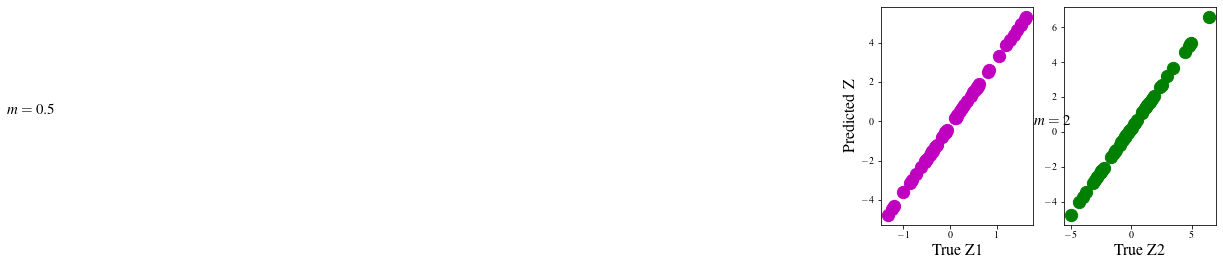

In [25]:
plt.subplot(1, 2, 1)

plt.scatter(Zp.detach().numpy()[:50,2], Z.detach().numpy()[:50,2], c='m', s=150)

# plt.plot(x, m*x+b, 'k')
plt.xlabel("True Z1", fontsize=16)
plt.ylabel("Predicted Z", fontsize=16)
plt.text(-20, 0.4, r'$m=0.5$',
         fontsize=15)
plt.subplot(1, 2, 2)
plt.scatter(Zp.detach().numpy()[:50,1], Z.detach().numpy()[:50,1], c='g', s=150)

# plt.plot(x1, m1*x1+b1, 'b')
plt.xlabel("True Z2", fontsize=16)
plt.text(-8, 0.4, r'$m=2$',
         fontsize=15)

## Generate results (Normal)

In [13]:
n_trials=5
dim_list = [6, 10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="normal_non_linear")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=2000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
    
    m=m+1
        
    
        

25000
condition number threshold: 2.239037
layer 1/2,  condition number: 2.2202537560294786


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.8756013781121936


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 1.895558
layer 1/2,  condition number: 1.857372232833113


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.8675772390482324


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 1.849041
layer 1/2,  condition number: 1.7663349482123343


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.7680856895871286


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 2.243809


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 1/2,  condition number: 2.0829277993570816
layer 2/2,  condition number: 2.0878863987696406


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 2.203198
layer 1/2,  condition number: 2.0794723821594787


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 2.089591372104892


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.288091
layer 1/2,  condition number: 3.148635494528012


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.2451177434204572


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.540346
layer 1/2,  condition number: 3.4316955268837357


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.4076018526780807


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.854760
layer 1/2,  condition number: 3.3157080739605447


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.7249265331802963


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.217307
layer 1/2,  condition number: 3.1084508066825842


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.197998077643236


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.438439
layer 1/2,  condition number: 2.764396257391674


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.328598564889553


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 8.989119
layer 1/2,  condition number: 8.71471919803647


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.742682210718767


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 9.329017
layer 1/2,  condition number: 8.454878371485986
layer 2/2,  condition number: 8.735454730033844


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 9.123546
layer 1/2,  condition number: 8.29511686855954


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.765715391138992


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 8.162761
layer 1/2,  condition number: 8.108581631528757


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 7.542482340372601


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 9.672207
layer 1/2,  condition number: 7.201320457130757


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 9.160662534999386


Training: 0it [00:00, ?it/s]

In [14]:
MCC_result

array([[0.99994027, 0.999994  , 0.99998758, 0.9999502 , 0.99999815],
       [0.99999311, 0.99997979, 0.99997504, 0.99998499, 0.99998408],
       [0.99981365, 0.99992054, 0.99988025, 0.99990201, 0.99992855]])

## Generate results (Uniform)

In [15]:
n_trials=5
dim_list = [6, 10,20]
s = len(dim_list)
MCC_result = np.zeros((s,n_trials))
m=0
for d in dim_list:
    for trial in range(n_trials):
        data_X, data_Z = data_generation_MLP(n=d, n_layers=2, cond_thresh_ratio=0.0, n_iter_cond_thresh=25000, n_data=15000, distribution="uniform_non_linear")
        k= len(data_X)
        train_data_X = []
        test_data_X  = []
        train_data_Z = []
        test_data_Z  = []
        train_size = 10000
        for i in range(k):
            train_data_X.append(data_X[i][:train_size])
            train_data_Z.append(data_Z[i][:train_size])
            test_data_X.append(data_X[i][train_size:])
            test_data_Z.append(data_Z[i][train_size:])  
        latent_comparison_model = Latent_comparison_model(d)
        train_loader = DataLoader(train_data_X, batch_size=BATCH_SIZE)
        trainer = Trainer(
            gpus=AVAIL_GPUS,
            max_epochs=2000,
            progress_bar_refresh_rate=20,
        )
        trainer.fit(latent_comparison_model, train_loader)
        
        Zp=latent_comparison_model(test_data_X[0])
        Z = test_data_Z[0]
        MCC_result[m][trial] = MCC(Z.detach().numpy(),Zp.detach().numpy())
    
    m=m+1
        
    
        

25000
condition number threshold: 2.092929
layer 1/2,  condition number: 1.6946382446164847


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 2.0813403840622824


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 1.861238
layer 1/2,  condition number: 1.7399384059465737


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.8162371042173246


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 2.121096
layer 1/2,  condition number: 1.9238546003198123


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 2.083434217534239


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 2.011473
layer 1/2,  condition number: 1.7773455255635993


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.9836706481547415


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 2.043286
layer 1/2,  condition number: 1.8205245723161816


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 700   
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 606   
-----------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


layer 2/2,  condition number: 1.9968718749991285


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.837890
layer 1/2,  condition number: 3.4084245914621745


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.7741654006740224


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 4.039048


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 1/2,  condition number: 3.9247352573111027
layer 2/2,  condition number: 3.996702737086388


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.951830
layer 1/2,  condition number: 3.392736033024425


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.7685675747446976


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 3.871876
layer 1/2,  condition number: 3.573616524326193


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 3.6159037639054326


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 4.144596
layer 1/2,  condition number: 3.869814516851981


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 1.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 1.0 K 
-----------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)


layer 2/2,  condition number: 4.108220868839708


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 7.202967
layer 1/2,  condition number: 7.025763704556807


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 6.7064483099401295


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 8.806797
layer 1/2,  condition number: 8.239643524302567


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.33534686319042


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 8.854860
layer 1/2,  condition number: 8.694020244594542


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 8.254054486671615


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 9.387527
layer 1/2,  condition number: 8.403069298529486


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 9.361125688881737


Training: 0it [00:00, ?it/s]

25000
condition number threshold: 6.967724
layer 1/2,  condition number: 6.655466154751754


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 2.1 K 
1 | act_fn  | ReLU   | 0     
2 | linear2 | Linear | 10.1 K
3 | act_fn2 | ReLU   | 0     
4 | linear3 | Linear | 2.0 K 
-----------------------------------
14.2 K    Trainable params
0         Non-trainable params
14.2 K    Total params
0.057     Total estimated model params size (MB)


layer 2/2,  condition number: 6.89235117887466


Training: 0it [00:00, ?it/s]

In [16]:
MCC_result

array([[0.9999886 , 0.99999541, 0.99997874, 0.99998145, 0.99993658],
       [0.9999922 , 0.99979694, 0.99968831, 0.99995207, 0.99991851],
       [0.9986362 , 0.99942116, 0.99620637, 0.99541172, 0.99771859]])